# Deep Learning with Python
3.6 Predicting house prices: a regression example

Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

Nos primeiros dois exemplos, estamos resolvendo problemas de classificação (prevendo rótulos discretos, ou seja, tinhamos opções de saída bem definidas).

Agora nós vamos trabalhar um exemplo de regressão logistica, no qual a previsão é de valores contínuos. 

O conjunto de dados utilizado aqui é o Boston Housing. 
Usamos o conjunto de dados do Boston Housing para prever os preços das moradias no subúrbio de Boston em meados da década de 1970. O conjunto de dados contém alguns dados daquele local na época, como leis criminais e taxas de impostos.

Em comparação com nossos dois primeiros conjuntos de dados de classificação, este conjunto de dados é bastante pequeno, apenas 506 dados. Sendo que 404 estão no conjunto de treinamento e 102 não estão no conjunto de teste. A magnitude dos dados de entrada para cada recurso nos dados não é a mesma.

Para saber mais informações sobre o conjunto de dados basta olhar aqui: 
https://www.kaggle.com/c/boston-housing

Vamos importar os dados primeiro (este conjunto de dados também está incluído no Keras):

In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape, test_data.shape)

(404, 13) (102, 13)


In [2]:
train_data[0:3]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.75520e+02, 3.26000e+00]])

In [3]:
train_targets[0:3]

array([15.2, 42.3, 50. ])

A unidade de dados nos destinos é de milhares de dólares americanos. Dado a epoca desses núrmero é compreensível o preço da casa relativamente barato (então não se empolguem, hoje em dia os valores são MUITO diferentes ok?):

In [4]:
min(train_targets), sum(train_targets)/len(train_targets), max(train_targets)


(5.0, 22.395049504950496, 50.0)

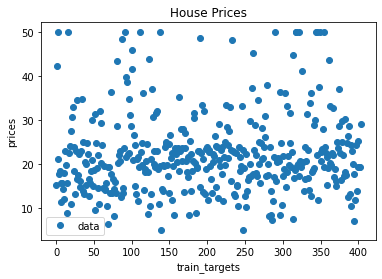

In [5]:
import matplotlib.pyplot as plt

x = range(len(train_targets))
y = train_targets

plt.plot(x, y, 'o', label='data')
plt.title('House Prices')
plt.xlabel('train_targets')
plt.ylabel('prices')
plt.legend()
plt.show()

# Preparação de dados
A faixa de valores de dados que fornecemos à rede neural não deve ser muito diferente. Embora a rede neural possa lidar com dados com grandes lacunas, ela não é nada boa. Para dados com uma lacuna tão grande, geralmente padronizamos cada recurso (normalização por recurso).

A operação específica é subtrair o valor médio da coluna para cada recurso (uma coluna da matriz de dados de entrada) e, em seguida, dividir por seu desvio padrão. Após fazer isso, os dados se tornarão centralizados em 0 e terão um desvio padrão (o desvio padrão é 1).

Isso pode ser feito facilmente com Numpy:

In [6]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

Preste atenção, o processamento do conjunto de teste usa a média e o desvio padrão do conjunto de treinamento.

Depois de processar os dados, você pode construir a rede e treinar (os rótulos não precisam ser processados, o que é mais conveniente do que a classificação)

## Construa a rede

Quanto menos dados, mais fácil de ocorre overfitting. Para desacelerar o overfitting, você pode usar uma rede menor.

Por exemplo, neste problema, usamos uma rede com apenas duas camadas ocultas, cada uma com 64 unidades:

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    return model

A última camada da rede possui apenas uma unidade e nenhuma função de ativação (portanto, é uma camada linear). Esta camada é nossa configuração padrão para a última etapa do problema de regressão de valor único contínuo.

Se uma função de ativação for adicionada, o valor de saída terá um limite de faixa, por exemplo, sigmóide irá limitar o valor a [0, 1]. Sem a função de ativação, o valor de saída desta camada linear é ilimitado.

Quando compilamos o modelo, a função de perda usada é mse (erro quadrático médio). Esta função retorna o quadrado da diferença entre o valor de destino previsto e verdadeiro. Essa perda é freqüentemente usada para problemas de regressão.

Em seguida, também usamos um indicador de treinamento que não foi usado antes do mae (erro médio absoluto), que é o valor absoluto da diferença entre a previsão e o alvo real.

# Verificação de ajuste - verificação K-fold
Já fizemos isso antes - para avaliar a rede e ajustar os parâmetros da rede (como o número de rodadas de treinamento), dividimos os dados em um conjunto de treinamento e um conjunto de validação. Desta vez, precisamos fazer o mesmo. Mas um problema é que temos poucos dados desta vez, então o conjunto de validação separado é muito pequeno (talvez apenas 100 dados). Nesse caso, dados diferentes selecionados para o conjunto de validação podem ter um grande impacto nos resultados da verificação (ou seja, as diferentes formas de dividir o conjunto de verificação podem causar uma grande variação nos resultados da verificação). Esta situação afetará nossa verificação do modelo.

Nessa situação estranha, a prática recomendada é usar a validação cruzada K-fold (validação cruzada K-fold).

Para saber mais sobre validação cruzada: https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/

Com a verificação K-fold, dividimos os dados em K partes (geralmente k = 4 ou 5) e, em seguida, instanciamos K modelos independentes, cada um usando K-1 pedaços de dados para treinar e, em seguida, usamos o restante para verificar , A pontuação de verificação do modelo final usa a média de K peças.

Implementação do código de verificação K-fold:

In [11]:
import numpy as np
import datetime
import tensorflow as tf

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []


for i in range(k):
    print(f'processing fold #{i} ({i+1}/{k})')
    
    # Prepare os dados de verificação
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare os dados de treinamento
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i+1) * num_val_samples :]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], 
         train_targets[(i+1) *  num_val_samples :]], 
        axis=0)
    
    #Construir e treinar modelos
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # Modelo de avaliação com conjunto de validação
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


np.mean(all_scores)


processing fold #0 (1/4)
processing fold #1 (2/4)
processing fold #2 (3/4)
processing fold #3 (4/4)


2.4146433

O que acabou de acontecer foi apenas uma jogada, agora nós mudamos, iteramos 500 rodadas e anotamos os resultados do treinamento:

In [12]:
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'processing fold #{i} ({i+1}/{k})')
    
    # Prepare os dados de verificação
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare os dados de treinamento
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i+1) * num_val_samples :]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], 
         train_targets[(i+1) *  num_val_samples :]], 
        axis=0)
    
    #Construir e treinar modelos
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)


print("Done.")

processing fold #0 (1/4)
processing fold #1 (2/4)
processing fold #2 (3/4)
processing fold #3 (4/4)
Done.


In [13]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

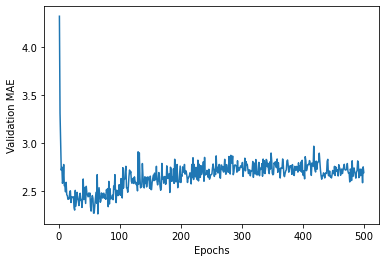

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Esta imagem é muito densa para ver claramente, então temos que lidar com isso:

Remova os dez primeiros conjuntos de dados, este fim está obviamente longe dos outros números;
Substitua cada ponto por uma média móvel exponencial dos pontos anteriores para suavizar a curva;

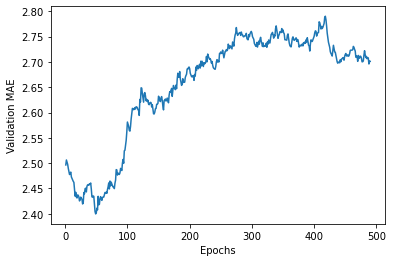

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

A partir dessa figura, pode-se perceber que, após quase 80 épocas, está sobreajuste.

Depois de tentar isso, encontramos os melhores parâmetros (o número de rodadas, o número de camadas da rede, todos podem ser tentados) e, em seguida, usamos os melhores parâmetros para treinar em todos os dados para obter o modelo de produção final.

In [16]:
# Treine o modelo final

model = build_model()
model.fit(train_data, train_targets, 
          epochs=80, batch_size=16, verbose=0)

# Avaliação final
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=0)
print(test_mse_score, test_mae_score)

17.805436676623774 2.7129285


O valor de test_mae_score mostra que a previsão do modelo que treinamos está a cerca de 2k + dólares americanos de distância da situação real. . . 😭